In [1]:
import torch
import random
from torchvision import datasets
import torchvision.transforms.functional as TF
from torchvision import transforms
from PIL import Image
import numpy as np
import os

In [2]:
import torch.nn.functional as F
import math

def bilinear(y):
    r""" Initialize with bilinear interpolation"""
    F_r = torch.FloatTensor([[1,2,1],[2,4,2],[1,2,1]])/4
    F_b = F_r
    F_g = torch.FloatTensor([[0,1,0],[1,4,1],[0,1,0]])/4
    bilinear_filter = torch.stack([F_r,F_g,F_b])[:,None]
    if y.is_cuda:
        bilinear_filter = bilinear_filter.cuda()
    res = F.conv2d(y, bilinear_filter,padding=1, groups=3)
    return res

def linrgb_to_srgb(img):
    """ Convert linRGB color space to sRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
#     assert img.dtype in [np.float32, np.float64]
    if isinstance(img, np.ndarray):
        img = img.copy()
    elif isinstance(img, torch.Tensor):
        img = img.clone()
    mask = img <= 0.0031308
    img[~mask] = (img[~mask]**(1/2.4))*(1.055) - 0.055
    img[mask] = img[mask] * 12.92
    return img

def srgb_to_linrgb(img):
    """ Convert sRGB color space to linRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
#     assert img.dtype in [np.float32, np.float64] 
    if isinstance(img, np.ndarray):
        img = img.copy()
    elif isinstance(img, torch.Tensor):
        img = img.clone()
    mask = img <= 0.04045
    img[~mask] = ((img[~mask]+0.055)/1.055)**2.4
    img[mask] = img[mask] / 12.92
    return img

def generate_mask(im_shape, pattern='RGGB'):
    if pattern == 'RGGB':
        # pattern RGGB
        r_mask = torch.zeros(im_shape)
        r_mask[0::2, 0::2] = 1

        g_mask = torch.zeros(im_shape)
        g_mask[::2, 1::2] = 1
        g_mask[1::2, ::2] = 1

        b_mask = torch.zeros(im_shape)
        b_mask[1::2, 1::2] = 1

        mask = torch.zeros((3,) + im_shape)
        mask[0, :, :] = r_mask
        mask[1, :, :] = g_mask
        mask[2, :, :] = b_mask
        return mask

In [3]:
from transforms.noising import PoissonGaussianNoise
from transforms.noising import realistic_noise

to_tensor = transforms.ToTensor()
class NoisedBayerDataset(datasets.ImageFolder):
    '''
    '''
    def __init__(self, dirs, noise_transform=None, scaler=1):

        super(NoisedBayerDataset, self).__init__(dirs, transform)
        self.noise_transform = noise_transform
        self.scaler = scaler

    def __getitem__(self, index):
        '''
        Args:
            index: Index of the triplet or the matches - not of a single image
        Returns:
        '''

        def load(img_path):
            """Convert image into numpy array
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """

            img = self.loader(img_path)
            return img

        img_path, class_id = self.imgs[index]
        img = load(img_path)
        img = np.asarray(img)/255.
        img = img*self.scaler
        img = to_tensor(img).float()
        img_linrgb = srgb_to_linrgb(img)
        c, h, w = img.shape
        raw_img = generate_mask((h,w))*img_linrgb
#         noised_raw_img = self.noise_transform(raw_img)
        if random.random() < 0.7:
            noised_raw_img = torch.from_numpy(realistic_noise(raw_img, 0.15, 0.15)).float()
        else:
            noised_raw_img = raw_img
        
        noised_raw_img = linrgb_to_srgb(noised_raw_img)
            
        return 255*noised_raw_img, 255*img, class_id, os.path.relpath(img_path, self.root)

In [4]:
train_data_dir = "/home/safin/datasets/CASIA-WebFace/CASIA-WebFace-sphereface/"
transform = transforms.Compose([
                         PoissonGaussianNoise(a=0.09, b=0.09, threshold=1)
                     ])
noised_dataset = NoisedBayerDataset(train_data_dir, noise_transform=transform, scaler=0.6)

In [16]:
noised_raw, gt, _, _ = noised_dataset[0]

In [6]:
_

'0000045/001.png'

In [13]:
os.path.join("/home/safin/datasets/t/", "home/safin/datasets/CASIA-WebFace/")

'/home/safin/datasets/t/home/safin/datasets/CASIA-WebFace/'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

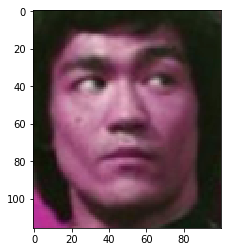

In [9]:
plt.imshow(gt.permute(1,2,0).numpy()/255/0.6)

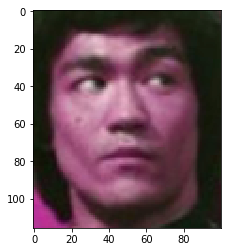

In [28]:
plt.imshow(linrgb_to_srgb(gt.permute(1,2,0).numpy()/255)/0.6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


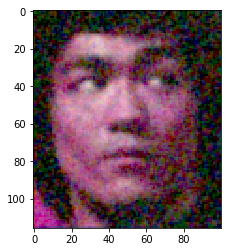

In [9]:
plt.imshow(linrgb_to_srgb(bilinear(torch.from_numpy(noised_raw).float().unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255)/0.6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


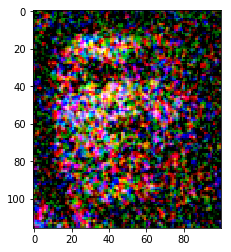

In [20]:
plt.imshow(bilinear(noised_raw.unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255/0.6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


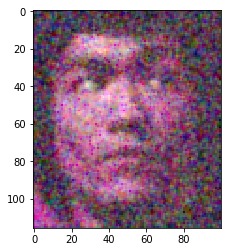

In [19]:
plt.imshow(linrgb_to_srgb(bilinear(srgb_to_linrgb(noised_raw).unsqueeze(0)).squeeze(0)).permute(1,2,0).numpy()/255/0.6)

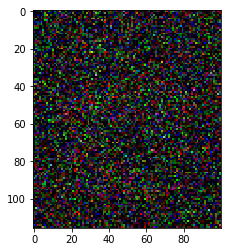

In [38]:
plt.imshow(noised_raw.permute(1,2,0).numpy()/255)

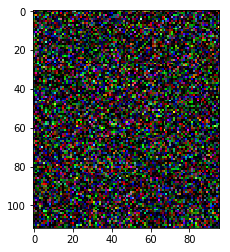

In [81]:
plt.imshow(noised_raw.permute(1,2,0).numpy()/255)

In [8]:
import tqdm
import queue
import threading
from PIL import Image
import numpy as np
import os

num_worker_threads = 10

def do_work(img, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(img.clip(0,255).astype(np.uint8)).save(path)

class ImageSaver(threading.Thread):
    def __init__(self, q, output_path):
        threading.Thread.__init__(self)
        self.q = q
        self.output_path = output_path
        
    def run(self):
        while True:
            item = self.q.get()
            if item is None:
                break
            img, path = item
            path = os.path.join(self.output_path, path)
            do_work(img, path)
            self.q.task_done()

In [9]:
q_noised = queue.Queue()
threads_noised = []

q_gt_lin = queue.Queue()
threads_gt_lin = []

bayer_path = "/home/safin/datasets/new_CASIA/bayer"

for i in range(num_worker_threads):
    t = ImageSaver(q_noised, bayer_path)
    t.start()
    threads_noised.append(t)

gt_lin_path = "/home/safin/datasets/new_CASIA/gt_lin"

for i in range(num_worker_threads):
    t = ImageSaver(q_gt_lin, gt_lin_path)
    t.start()
    threads_gt_lin.append(t)

In [17]:
noised.shape

(3, 116, 100)

In [15]:
Image.fromarray(noised.clip(0,255).astype(np.uint8))

TypeError: Cannot handle this data type

In [10]:
import time

t_start = time.time()

for sample in tqdm.tqdm_notebook(noised_dataset):
    noised, gt_lin, _ , path = sample
    noised = noised.permute(1,2,0).numpy()
    gt_lin = gt_lin.permute(1,2,0).numpy()
    q_noised.put_nowait((noised, path))
    q_gt_lin.put_nowait((gt_lin, path))


q_noised.join()
for i in range(num_worker_threads):
    q_noised.put(None)

for t in threads_noised:
    t.join()
    
q_gt_lin.join()
for i in range(num_worker_threads):
    q_gt_lin.put(None)

for t in threads_gt_lin:
    t.join()

t_end = time.time()
print(t_end-t_start)

SyntaxError: broken PNG file (chunk b'\xa5\xce\xb85') (<string>)

In [ ]:
print("Done")